## Conditional GANs

Here we explore Conditional GANs, where we feed image labels into both generator and discriminator as additional input layers such that the labels and the image are combined in a joint hidden representation.

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

In [3]:
# how many samples per batch to load
batch_size = 64 

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

100.1%

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw


113.5%

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw


100.4%

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw


180.4%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...
Done!


In [5]:
# prepare data loader.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

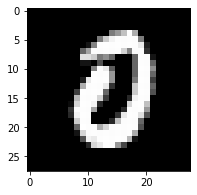

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [33]:
labels.dtype

torch.int64

## Define Discriminator and Generator
 
Here we define the discriminator and generator of conditional GANs. As said earlier, this time we will also add labels to the input of both generator and discriminator.

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, label_size, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define embeddings layer for labels
        self.embed = nn.Embedding(label_size, label_size)
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size + label_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, image, labels):
        # flatten image
        image = image.view(-1, 28*28)
        
        # pass labels through embedding layer
        labels = self.embed(labels)
        
        # concatenate image and labels
        x = torch.cat((image, labels), 1)
        
        # all hidden layers
        # We use LeakyRelu here, because GANs don't work well with sparse gradients like ReLu.
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        
        # We use dropout as a form of adding noise to the input.
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        # final layer. we don't use sigmoid here because we use BCEWithLogits loss function.
        out = self.fc4(x)

        return out

In [24]:
class Generator(nn.Module):

    def __init__(self, label_size, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define embeddings layer for labels
        self.embed = nn.Embedding(label_size, label_size)
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size + label_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, image, labels):
        # pass labels through embeddings
        labels = self.embed(labels)
        
        #concatentate image and labels
        x = torch.cat((image, labels), 1)
        
        
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        # final layer with tanh applied. We normalize the images between -1 and 1 using tanh.
        out = F.tanh(self.fc4(x))

        return out

## Model Hyperparameters

In [25]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784 # 28*28
# Size of first hidden layer in the generator
g_hidden_size = 32

# label size
label_size = 10 # 0-9

## Build complete network

In [26]:
 # instantiate discriminator and generator
D = Discriminator(label_size, input_size, d_hidden_size, d_output_size)
G = Generator(label_size, z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (embed): Embedding(10, 10)
  (fc1): Linear(in_features=794, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (embed): Embedding(10, 10)
  (fc1): Linear(in_features=110, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


## Calculate Losses

We define two types of losses:

1. `real_loss` which calculates the loss on the real image dataset.
2. `fake_loss` which calculates the loss on the fake images generated by the generator.

#### Discriminator Loss

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. To help the discriminator generalize better, the labels are **reduced a bit from 1.0 to 0.9**. For this, we'll use the parameter `smooth`; if True, then we should smooth our labels.

Similarly, for fake images we want `D(fake_images)=0`. Hence the total loss for the discriminator becomes ` d_real_loss + d_fake_loss`.

#### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

#### Loss function

We use `BCEWithLogitsLoss()` as our loss function, that combines a `Sigmoid layer` and the `BCELoss` in one single class. We will need to apply sigmoid to our discriminator output in order to get the output of the final layer between 0 and 1 (since our class labels are 0 for fake and 1 for real) and then calculate the loss. 

In [28]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9 
    else:
        labels = torch.ones(batch_size) # real labels = 1

    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Training

We defined Adam optimizers for discriminator and generator.

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images + labels      
2. Generate fake images and labels
3. Compute the discriminator loss on fake, generated images + labels     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images and labels
2. Compute the discriminator loss on fake images + labels, using **flipped** real labels (0 -> 1, not to be confused with generated labels)!
3. Perform backpropagation + an optimization step to update the generator's weights
4. We don't update discrminator weights during Generator training.

In [30]:
# Let's now define the optimizers
import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [35]:
# Let's start training
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_labels = np.random.randint(0, label_size, sample_size)
fixed_labels = torch.from_numpy(fixed_labels).long()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, real_labels) in enumerate(train_loader):
        
        batch_size = real_images.size(0) # batch_size = 64
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images, real_labels)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size)) # size = (64, 100)
        z = torch.from_numpy(z).float()
        fake_labels = np.random.randint(0, label_size, batch_size)
        fake_labels = torch.from_numpy(fake_labels).long()
        fake_images = G(z, fake_labels)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images, fake_labels)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size)) # size = (64, 100)
        z = torch.from_numpy(z).float()
        fake_labels = np.random.randint(0, label_size, batch_size)
        fake_labels = torch.from_numpy(fake_labels).long()
        fake_images = G(z, fake_labels)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images, fake_labels)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step() # But we only update the generator

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z, fixed_labels)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples, to evaluate later. 
with open('train_samples_cgan.pkl', 'wb') as f:
    pkl.dump(samples, f)

c:\python37\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 0.9353 | g_loss: 3.7243
Epoch [    1/  100] | d_loss: 1.1919 | g_loss: 1.1273
Epoch [    1/  100] | d_loss: 1.2642 | g_loss: 1.3056
Epoch [    2/  100] | d_loss: 1.4051 | g_loss: 0.8486
Epoch [    2/  100] | d_loss: 1.1361 | g_loss: 1.1209
Epoch [    2/  100] | d_loss: 0.9962 | g_loss: 2.4227
Epoch [    3/  100] | d_loss: 1.1459 | g_loss: 1.2240
Epoch [    3/  100] | d_loss: 1.2022 | g_loss: 1.9850
Epoch [    3/  100] | d_loss: 1.2011 | g_loss: 0.9165
Epoch [    4/  100] | d_loss: 1.3849 | g_loss: 1.1763
Epoch [    4/  100] | d_loss: 1.2217 | g_loss: 1.6817
Epoch [    4/  100] | d_loss: 1.2817 | g_loss: 1.1188
Epoch [    5/  100] | d_loss: 1.0304 | g_loss: 1.5783
Epoch [    5/  100] | d_loss: 1.2675 | g_loss: 2.4374
Epoch [    5/  100] | d_loss: 1.0772 | g_loss: 2.4676
Epoch [    6/  100] | d_loss: 1.1695 | g_loss: 1.4864
Epoch [    6/  100] | d_loss: 1.0541 | g_loss: 1.3554
Epoch [    6/  100] | d_loss: 1.2919 | g_loss: 0.9525
Epoch [    7/  100] | d_loss

## Save objects

In [36]:
# Save the losses
np.save('losses_cgan', losses)

In [37]:
# Save the discriminator
torch.save(D.state_dict(), 'discriminator_cgan.pth')

In [38]:
# Save the generator
torch.save(G.state_dict(), 'generator_cgan.pth')

## Plot Training Loss

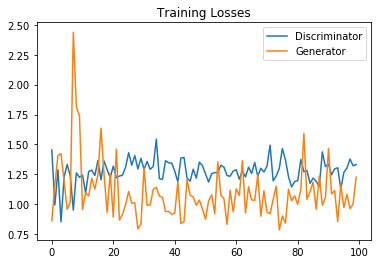

In [39]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Check generated samples to evaluate performance

One of the main evaluation metrics of GANs is to manually inspect the quality of generated images and hence we will look at samples generated by the generator over time.

In [40]:
# Load samples from generator, taken while training
with open('train_samples_cgan.pkl', 'rb') as f:
    samples = pkl.load(f)

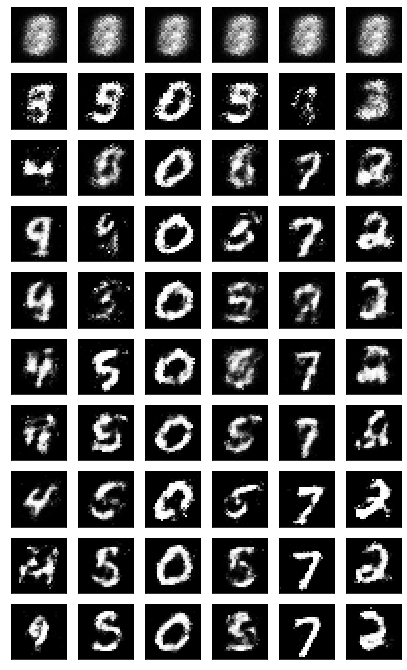

In [41]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

As we can see the generator learns to generate clearer images over time.

## Generate samples from generator

We will generate sample images here with supplied labels. The labels are the real labels that we used during our training. For MNIST, they range from 0-9 for the digits.

In [98]:
# Load the saved generator model
G = Generator(label_size, z_size, g_hidden_size, g_output_size)
G.load_state_dict(torch.load('generator_cgan.pth'))
G.eval()

Generator(
  (embed): Embedding(10, 10)
  (fc1): Linear(in_features=110, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [99]:
# Initialize a random vector
rand_image = torch.from_numpy(np.random.uniform(-1, 1, size=(1, z_size))).float()

In [100]:
# label defines the type of image we want to generate. ranges from 0-9
label = torch.tensor([0]).long()

In [101]:
rand_g = G(rand_image, label)

c:\python37\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


c:\python37\lib\site-packages\torch\tensor.py:293: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


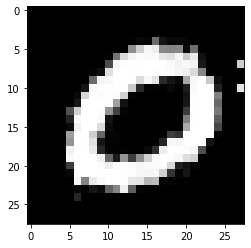

In [102]:
# we need to detach the image, so that it's out of the graph
rand_g = rand_g.detach()
plt.imshow(rand_g.resize(28, 28), cmap='Greys_r')